# Image Segmentation and Compression using K-Means Clustering
We can here visiualise image as a data set, with 3 features. We can simply employ K-Means clustering as before and segment the points into different clusters. Here we do not cluster the points based on the location but only based on their RGB values

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
# read the image as rgb values
img = plt.imread('img3.jpg')
# view the image
plt.imshow(img)
dimesion = img.shape
print(dimesion)

(700, 700, 3)


So here as image is a 700 x 700 pixel image, so we have 700 x 700 = 490000 data points, each data point represented by 3 features R G and B values.

In [91]:
# make the rgb values into a single array
img_flat = img.reshape(dimesion[0] * dimesion[1], dimesion[2])

# make a dataframe with the rgb values
df = pd.DataFrame(img_flat)

# insert labels to the dataframe
df.columns = ['R', 'G', 'B']

df.describe()

,R,G,B
count,490000.000000,490000.000000,490000.000000
mean,61.969843,55.202382,42.349445
std,49.362423,41.247614,41.002967
min,0.000000,0.000000,0.000000
25%,29.000000,28.000000,17.000000
50%,44.000000,44.000000,28.000000
75%,74.000000,64.000000,47.000000
max,224.000000,210.000000,217.000000


## K-Means Clustering 
We will employ the K-Means clustering algorithm to segment an image into a number of clusters. We will employ the same code employd in part 01. The only change we made is after calclulating a means (centroids) we will find the nearest points exisitng int the data and take them as centroids. This will help us select the already exisitng colors.

In [92]:
# k means algorithm

# one iteration of a e step of k means algorithm
def e_step(df, mu):
    # calculate the distance between each data point and each mean
    dist = np.zeros((len(df), len(mu)))
    for i in range(len(mu)):
        dist[:, i] = np.linalg.norm(df - mu[i], axis=1)
    # assign each data point to the mean with the smallest distance
    idx = np.argmin(dist, axis=1)
    return idx
# one iteration of a m step of k means algorithm
def m_step(df, idx):
    # calculate the mean of each cluster
    mu = np.zeros((len(np.unique(idx)), len(df.columns)))
    for i in range(len(np.unique(idx))):
        mu[i] = df[idx == i].mean(axis=0)
    # convert the mu to nearest point available in df
    for i in range(len(mu)):
        mu[i] = df.iloc[np.argmin(np.linalg.norm(df - mu[i], axis=1))]
    return mu

def k_means(df, k, max_iter=10000):
    # initialize the means
    mu = np.zeros((k, len(df.columns)))
    for i in range(k):
        mu[i] = df.iloc[np.random.randint(0, len(df))]
    # initialize the clusters
    idx = np.zeros(len(df))
    # initialize the old clusters
    old_idx = np.zeros(len(df))
    # initialize the iteration counter
    iter = 0
    # lets save the idx and mu and cost for each iteration
    idx_mu = []
    # get initial cost
    cost = np.sum(np.linalg.norm(df - mu[idx.astype(int)], axis=1))
    idx_mu.append([idx.copy(), mu.copy(), cost ])
    # run the k means algorithm until convergence
    while iter < max_iter:
        # run the e step
        old_idx = idx.copy()
        idx = e_step(df, mu)
        cost = np.sum(np.linalg.norm(df - mu[idx], axis=1))
        idx_mu.append([idx.copy(), mu.copy(), cost])
        # run the m step
        mu = m_step(df, idx)
        # save the idx and mu and cost for each iteration
        cost = np.sum(np.linalg.norm(df - mu[idx], axis=1))
        idx_mu.append([idx.copy(), mu.copy(), cost])
        # check for convergence
        iter += 1
        if np.array_equal(idx, old_idx):
            break
    # caclutate the cost
    cost = 0
    for i in range(len(idx)):
        cost += np.linalg.norm(df.iloc[i] - mu[idx[i]])

    # store extra information about the algorithm in info dictionary
    # this will be employful for getting insights from the algorithm
    info = {'k': k ,'iter': iter, 'final_cost' : cost, 'idx_mu': idx_mu}
    return idx, mu, info

Now lets run the algorithm with different number of clusters. Different number of clusters will result in different number of colors.

In [105]:
# lets cluster the data using different values of k
k_range = [2,3,4,5,6]
# lets run the algorithm for different values of k
clustered_imgs = {}
for k in k_range:
    idx, mu, info = k_means(df, k)
    # save the clustered image
    vector_quant = idx
    code_book = mu.astype(int)
    clustered_imgs[k] = {'vector_quant': vector_quant, 'code_book': code_book}


### Visualising the clusterered images

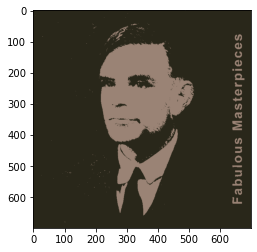

In [106]:
vq = clustered_imgs[2]['vector_quant']
# get the rgb values for the clustered image using code book
clustered_img = np.zeros((len(vq), len(df.columns)))
for i in range(len(vq)):
    clustered_img[i] = clustered_imgs[2]['code_book'][vq[i]]
clustered_img = clustered_img.reshape(dimesion[0], dimesion[1], dimesion[2])
# view the clustered image
# find distinct values of the clustered image

# view the clustered image
plt.imshow(clustered_img.astype(int))

With K = 2, the image is already recognizable, even in the monochrome mode, but it has lost several of the details

In [107]:
def recreateImg(vector_quant, code_book, dimesion):
    # create an image of the same size as the original
    img_recreated = np.zeros((len(vector_quant), dimesion[2]))
    # assign each pixel the mean of the cluster it belongs to
    for i in range(len(vector_quant)):
        img_recreated[i] = code_book[vector_quant[i]]
    
    # reshape the image
    img_recreated = img_recreated.reshape(dimesion[0], dimesion[1], dimesion[2])
    img_recreated = img_recreated.astype(int)
       
    return img_recreated

Lets see the image with some higher values of K, and see how the image changes.

In [113]:
# plot the clustered images as subplots
fig, ax = plt.subplots(1, 5, figsize=(40, 8))
for i in range(5):
    ax[i].imshow(recreateImg(clustered_imgs[i+2]['vector_quant'], clustered_imgs[i+2]['code_book'], dimesion))
    ax[i].set_title('k = {}'.format(i+2))
    ax[i].axis('off')

So we can see that the image is fairly well segmented, and the colors are more distinct.

### Further Scope of the Image Segmentation
We have employd only RGB values for the image segmentation. We can also employ other features like location. This will help in coloring near by clusters with similar colors. We can find mean based on R G B, X and Y and then assign the R G B of the certoids to the points. This will help in coloring the points near the centroid with similar colors. We can insert wights to this X and Y to tweak our results.